In [1]:
# Food Classification and Nutrition Analysis

## Load Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, HTML
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
# Set model path
MODEL_PATH = "food101_model.pth"

# Load the saved model data
model_data = torch.load(MODEL_PATH, map_location=torch.device("cpu"))

if isinstance(model_data, dict) and "model_state_dict" in model_data:
    print("Detected dictionary with 'model_state_dict'. Extracting weights...")

    # Initialize a new ResNet50 model
    model = models.resnet50(pretrained=False)

    # Modify FC layer to match the saved model
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Adjust this to match your saved model
        nn.ReLU(),
        nn.Linear(512, 101)  # Assuming Food101 has 101 classes
    )

    # Load only the weights
    model.load_state_dict(model_data["model_state_dict"], strict=False)  # Allow mismatches
    model.eval()
    print("Model loaded successfully using extracted state_dict.")

elif isinstance(model_data, dict):
    print("Detected pure state_dict. Loading into ResNet50 model...")
    model = models.resnet50(pretrained=False)
    model.load_state_dict(model_data, strict=False)  # Allow mismatches
    model.eval()
    print("Model loaded successfully using state_dict.")

else:
    print("Detected full model. Loading directly...")
    model = model_data
    model.eval()
    print("Model loaded successfully as a full model.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Adrian De Guzman\AppData\Local\Temp\ipykernel_17176\802032688.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(MODEL_PATH, map_location=t

Detected dictionary with 'model_state_dict'. Extracting weights...
Model loaded successfully using extracted state_dict.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# Define preprocessing for input image (ResNet50 expects 224x224 images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

food_classes = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice',
    'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich',
    'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup',
    'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
    'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters',
    'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
    'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto',
    'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits',
    'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'
]

In [4]:
# Load an example image
IMAGE_PATH = "4919.jpg"  # Replace with an actual food image

if os.path.exists(IMAGE_PATH):
    image = Image.open(IMAGE_PATH).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        output = model(image)
    
    # Convert raw tensor to class label
    predicted_index = output.argmax(dim=1).item()  # Get index of max value
    predicted_class = food_classes[predicted_index]  # Get class name

    print(f"Predicted food class: {predicted_class} with index {predicted_index}")

else:
    print(f"Image not found: {IMAGE_PATH}. Please provide a valid image.")

Predicted food class: beef_carpaccio with index 3


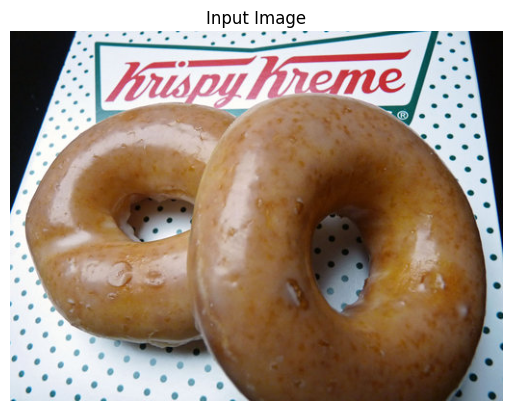

Predicted food class: beef_carpaccio with index 3


In [ ]:
# Load an example image
IMAGE_PATH = "108879.jpg"  # Replace with an actual food image

if os.path.exists(IMAGE_PATH):
    image = Image.open(IMAGE_PATH).convert("RGB")

    # Display the image
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title("Input Image")
    plt.show()

    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        output = model(image)
    
    # Convert raw tensor to class label
    predicted_index = output.argmax(dim=1).item()  # Get index of max value
    predicted_class = food_classes[predicted_index]  # Get class name

    print(f"Predicted food class: {predicted_class}")

else:
    print(f"Image not found: {IMAGE_PATH}. Please provide a valid image.")